# State Assignment Using Decision Trees
Explore doing state assignment with decision trees. 

- Handle small classes by combining classes.
- Do crossvalidation
- Explore sensitivity to perturbations in the data

In [1]:
import init
from common import constants as cn
from common.data_provider import DataProvider
from common import transform_data
from common_python.statistics import empirical_distribution_generator, density, multiple_density, util_statistics
from common_python.plots import util_plots


from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections

%matplotlib inline

## Generate Classification Data

1. T0 is eliminated
1. Normoxia is combined with Resuscitation (because of small number of Normoxia)
1. Perfectly correlated genes are combined

In [2]:
provider = DataProvider()
provider.do()

In [3]:
# Geenrate the feature data
def makeFeatureDF(provider):
    df_Xdata = transform_data.aggregateGenes(provider=provider)
    df_Xdata = df_Xdata.T
    df_Xdata = df_Xdata.drop(index="T0")
    data_features = df_Xdata.columns
    df_Xdata.columns = range(len(data_features))
    return df_Xdata

def makeFeatureColumns(provider):
    df_X = transform_data.aggregateGenes(provider=provider)
    df_X = df_X.T
    return df_X.columns.tolist()


df_Xdata = makeFeatureDF(provider)
df_Xdata.head()

,0,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
T1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [4]:
makeFeatureColumns(provider)

['Rv1927',
 'Rv1129c',
 'Rv3085',
 'Rv3083',
 'Rv3086',
 'Rv2226',
 'Rv0260c',
 'Rv1365c',
 'Rv3084',
 'Rv0975c',
 'Rv3087',
 'Rv1542c--Rv3088--Rv3089',
 'Rv1135A',
 'Rv2309A',
 'Rv0976c',
 'Rv1137c',
 'Rv3252c',
 'Rv2107',
 'Rv0252',
 'Rv3741c',
 'Rv0047c',
 'Rv1807',
 'Rv1808',
 'Rv1734c',
 'Rv1996',
 'Rv2160c',
 'Rv2160A',
 'Rv3251c',
 'Rv3616c',
 'Rv2645',
 'Rv0860',
 'Rv0859',
 'Rv2590',
 'Rv0280',
 'Rv1396c',
 'Rv2159c',
 'Rv0578c',
 'Rv3131',
 'Rv3130c',
 'Rv1738',
 'Rv0079',
 'Rv2031c',
 'Rv1131',
 'Rv1465',
 'Rv1130',
 'Rv3406',
 'Rv1128c',
 'Rv1806',
 'Rv2661c',
 'Rv1804c',
 'Rv3249c',
 'Rv3174',
 'Rv1169c',
 'Rv0232',
 'Rv2660c',
 'Rv1805c',
 'Rv2551c',
 'Rv2633c',
 'Rv0586',
 'Rv0244c--Rv1535--Rv1536--Rv2225--Rv3477',
 'Rv3615c',
 'Rv3855',
 'Rv1904--Rv3478',
 'Rv1772',
 'Rv0046c',
 'Rv3614c',
 'Rv0250c',
 'Rv3340',
 'Rv1623c',
 'Rv1875',
 'Rv2990c',
 'Rv3854c',
 'Rv3250c',
 'Rv3126c',
 'Rv2396',
 'Rv2161c',
 'Rv1989c',
 'Rv0755A',
 'Rv3290c',
 'Rv0474',
 'Rv3127',
 'Rv1813

There are only two Noroxia states, one of which is a reference state. So, for the class data, we combine
Noroxia with Resusitation.

In [5]:
# Prepare the state data
def makeClassSer(provider):
    ser_state = provider.df_stage_matrix[cn.STAGE_NAME]
    ser_state = ser_state.drop(index="T0")
    ser_state = ser_state.copy()
    ser_state[ser_state == 'Normoxia'] = 'Resuscitation'
    # Create converter from state name to numeric index
    states = ser_state.unique()
    state_dict = {k: v for v, k in enumerate(states)}
    ser = ser_state.apply(lambda k: state_dict[k] )
    return ser
ser_Ydata = makeClassSer(provider)

In [6]:
ser_Ydata

timepoint
T1     0
T2     1
T3     1
T4     1
T5     1
T6     1
T7     1
T8     2
T9     2
T10    3
T11    2
T12    3
T13    3
T14    3
T15    3
T16    4
T17    4
T18    4
T19    2
T20    2
T21    2
T22    0
T23    0
T24    0
T25    0
Name: name, dtype: int64

## Common Codes

In [7]:
# View the tree
def viewTree(df_X, ser_Y):
    dtree = tree.DecisionTreeClassifier(criterion = "entropy")
    dtree = dtree.fit(df_X, ser_Y)
    with open("dtree.dot", 'w') as fd:
        dotfile = tree.export_graphviz(dtree, out_file = fd, feature_names = df_X.columns)
    !dot -Tpng dtree.dot -o dtree.png

## sklearn Decision Trees

In [8]:
clf = DecisionTreeClassifier(random_state=0)
iris = load_iris()
cross_val_score(clf, iris.data, iris.target, cv=10)

array([1.        , 0.93333333, 1.        , 0.93333333, 0.93333333,
       0.86666667, 0.93333333, 1.        , 1.        , 1.        ])

In [9]:
type(iris.data)

numpy.ndarray

In [10]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [11]:
# A different approach. Using dot directly.
from pandas import read_csv, DataFrame
from sklearn import tree
from os import system

Y = iris.target
X = pd.DataFrame(iris.data)

dtree = tree.DecisionTreeClassifier(criterion = "entropy")
dtree = dtree.fit(X, Y)

with open("dtree.dot", 'w') as fd:
    dotfile = tree.export_graphviz(dtree, out_file = fd, feature_names = X.columns)
!dot -Tpng dtree.dot -o dtree.png
#system("firefox file:///%s/dtree.png" % os.getcwd() )

<img src="dtree.png"> 

## Analyze Expression Data

In [12]:
clf = DecisionTreeClassifier(random_state=0)
results = cross_val_score(clf, makeFeatureDF(provider), makeClassSer(provider), cv=3)
print("Mean: %f\nStd: %f" % (np.mean(results), np.std(results)))

Mean: 0.804233
Std: 0.185261


In [13]:
viewTree(df_Xdata, ser_Ydata)

The gene groups used in the resulting tree are listed below.

In [14]:
gene_groups = [109,616, 218, 1087]
features = makeFeatureColumns(provider)
for group in gene_groups:
    print(features[group])

Rv0728c--Rv3242c
Rv0668
Rv0738
Rv2165c--Rv2497c


In [15]:
len(makeFeatureColumns(provider))

1515

In [16]:
gene_groups = [109,616, 218, 1087]
features = makeFeatureColumns(provider)
df_plot =  transform_data.aggregateGenes(provider=provider)
df_plot = df_plot.drop(columns=["T0"])
column_names = [features[g] for g in gene_groups]
df_plot = df_plot.T
df_plot = df_plot[column_names]
df_plot = df_plot.copy()
df_plot = df_plot.T
df_plot.columns = [c.replace("T","") for c in df_plot.columns]
df_plot.columns = ["" if int(c) % 2 == 0 else c for c in df_plot.columns]
df_plot.head()

,1,,3,,5,,7,,9,,...,,17,,19,,21,,23,,25
Rv0728c--Rv3242c,0,-1,-1,-1,-1,-1,-1,0,0,-1,...,0,0,0,1,0,0,0,0,0,0
Rv0668,0,0,0,0,0,0,0,-1,-1,-1,...,-1,-1,0,-1,-1,-1,0,0,0,0
Rv0738,0,-1,-1,-1,-1,-1,-1,1,1,-1,...,0,0,0,1,1,1,0,0,0,-1
Rv2165c--Rv2497c,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0


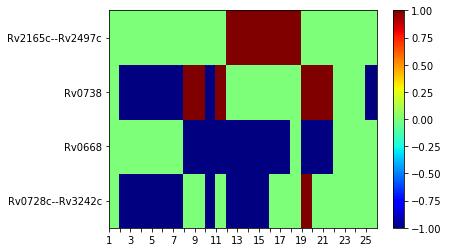

In [17]:

util_plots.plotCategoricalHeatmap(df_plot, xoffset=0)

**Notes**
1. Expect few changes in gene expression between adjacent states

# Analyze Decorrelated Expression Data

In [18]:
df_decor = util_statistics.decorrelate(df_Xdata.T)
df_Xdata_decor = df_decor.T
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, df_Xdata_decor, ser_Ydata, cv=3)

array([0.33333333, 0.22222222, 0.14285714])

In [19]:
viewTree(df_Xdata_decor, ser_Ydata)

In [20]:
xvs = []
for _ in range(1000):
    df_decor = util_statistics.decorrelate(df_Xdata_decor.T)
    df_Xdata_decor = df_decor.T
    clf = DecisionTreeClassifier(random_state=0)
    xvs.append(np.mean(cross_val_score(clf, df_Xdata_decor, ser_Ydata, cv=3)))

In [21]:
xvs[0:10]

[0.19576719576719573,
 0.1693121693121693,
 0.037037037037037035,
 0.19576719576719573,
 0.24338624338624337,
 0.31746031746031744,
 0.31746031746031744,
 0.37566137566137564,
 0.37566137566137564,
 0.2698412698412698]

Text(0.16, 0.6, 'q')

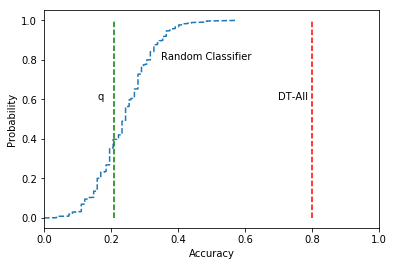

In [22]:
xvs.sort()
yvs = [(1.0*v) / len(xvs) for v in range(len(xvs))]
plt.plot(xvs, yvs, [0.8, 0.8], [0, 1], 'r', linestyle='dashed')
plt.plot([0.21, 0.21], [0, 1], 'g', linestyle='dashed')
plt.xlim(0, 1.0)
plt.xlabel("Accuracy")
plt.ylabel("Probability")
plt.text(0.7, 0.6, "DT-All")
plt.text(0.35, 0.8, "Random Classifier")
plt.text(0.16, 0.6, "q")

**Notes**
1. Calculate a distribution of average accuracy for decorrelated data. Plot CDF and show where data lies with std.
1. This looks like a logistic distribution centered at the expected accuracy for a random classifier (selects class from the distribution of observed classes).

# Effect of Fractional Decorrelations

Bug is that I'm sampling X but not keeping the associated Y.

In [23]:
def calcClassificationAccuracy(provider, frac):
    """
    :param float frac: fraction decorrelate
    :return float, float: mean, std of classification error
    """
    NUM_REPETITIONS = 20
    df_X = makeFeatureDF(provider)
    ser_Y = makeClassSer(provider)
    generator = empirical_distribution_generator.EmpiricalDistributionGenerator(df_X)
    df = generator.synthesize(-1, frac)
    means = []
    stds = []
    for _ in range(NUM_REPETITIONS):
        generator = empirical_distribution_generator.EmpiricalDistributionGenerator(df)
        df = generator.synthesize(-1, frac)
        clf = DecisionTreeClassifier(random_state=0)
        accuracies = cross_val_score(clf, df, ser_Y, cv=3)
        means.append(np.mean(accuracies))
        stds.append(np.std(accuracies) / np.sqrt(len(accuracies)))
    return np.mean(means), np.mean(stds)

In [24]:
calcClassificationAccuracy(provider, 0.02)

(0.6634920634920636, 0.07755292840703744)

In [25]:
fracs = [0.01*v for v in range(31)]
results = []
for frac in fracs:
    results.append(calcClassificationAccuracy(provider, frac))
results

[(0.8042328042328041, 0.10696034709034433),
 (0.6071428571428572, 0.07887763760261432),
 (0.6611111111111112, 0.06412185112892463),
 (0.5515873015873016, 0.061510485914139004),
 (0.4007936507936508, 0.05504303200607412),
 (0.43465608465608463, 0.06202431392377387),
 (0.3682539682539682, 0.07241522911868407),
 (0.3904761904761905, 0.06586748690095443),
 (0.3743386243386243, 0.06475208523410454),
 (0.31851851851851853, 0.06367759566940132),
 (0.35608465608465606, 0.07072049137058341),
 (0.3111111111111111, 0.05979287274854461),
 (0.31296296296296294, 0.06473159195269679),
 (0.27380952380952384, 0.057878033758983136),
 (0.3023809523809523, 0.05414426779084671),
 (0.25026455026455025, 0.06247949254368196),
 (0.29391534391534385, 0.05785335262315198),
 (0.23624338624338623, 0.06673709141190493),
 (0.28174603174603174, 0.06381682230150779),
 (0.2605820105820105, 0.05476487522049465),
 (0.26296296296296295, 0.052620945759319436),
 (0.2706349206349206, 0.056203264671660744),
 (0.24417989417989

In [26]:
def calcRandomClassifierAccuracy(ser):
    counts = collections.Counter(ser)
    probs = [(1.0*v)/len(df) for v in counts.values()]
    return sum(p**2 for p in probs)

In [27]:
calcRandomClassifierAccuracy(ser_Y)

NameError: name 'ser_Y' is not defined

In [ ]:
ser_Y

In [ ]:
collections.Counter(provider.df_stage_matrix['name'])

In [ ]:
provider.df_stage_matrix.head()

In [ ]:
#means, stds = zip(*results)
fig, ax = plt.subplots()
ax.errorbar(fracs, means, yerr=stds)
ax.plot([0, fracs[-1]], [.21, .21], linestyle="dashed")
plt.xlabel("frac")
plt.ylabel("accuracy")
plt.ylim([0, 1])